In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pengyu.zhang/project/superres/ProbSR/Experiment2

/home/pengyu.zhang/project/superres/ProbSR/Experiment2


In [3]:
from data_generation import *
from scipy.linalg import sqrtm
from downscaling import *
from utils import *
import time
import random

In [4]:
%cd Bicubic_Downsampling

/home/pengyu.zhang/project/superres/ProbSR/Experiment2/Bicubic_Downsampling


In [23]:
N_low = 40
N_high = 160
scale = 4
a,b,c,d = 2.5,-2.7,2.1,1

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

In [24]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c,d)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.002
ll_sigma = 0.001

In [26]:
A_high = csr_matrix(A_high)

In [27]:
operator = (A_high.T) * (1/prior_sigma**2)
b_high = create_forcing_term(N_high,a,b,c,d)

In [28]:
G1 = DownScale().to(device)
G1.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment2/Bicubic_Downsampling/models/model1/40_160/lr0.003_gamma0.5_stepsize30_K70_llsigma_0.002_psigma0.002/ckpt/current_epoch.pth')['netG'])

G2 = DownScale().to(device)
G2.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment2/Bicubic_Downsampling/models/model2/40_160/lr0.003_gamma0.5_stepsize50_K80_llsigma_0.002_psigma0.002/ckpt/current_epoch.pth')['netG'])

G3 = U_net(1,1).to(device)
G3.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment2/Bicubic_Downsampling/models/model3/40_160_unet/lr0.001_gamma0.5_stepsize100_K100_llsigma_0.002_psigma_0.002/ckpt/current_epoch.pth')['netG'])

#G4 = ResidualLearning().to(device)
#G4.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment1/Bicubic_Downsampling/models/after_pre_train/model3_8samples/40_160/lr0.0001_gamma0.5_stepsize30_K50_llsigma_0.001_psigma_0.002/ckpt/current_epoch.pth')['netG'])

<All keys matched successfully>

In [37]:
a,b,c,d = -3.6,2.7,2.1,1
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c,d)
b_high = create_forcing_term(N_high,a,b,c,d)


# Direct bicubic
x = torch.tensor(w_low).to(torch.float32)
w_sr = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode="bicubic").reshape(N_high,N_high)
error1 = abs(w_high - w_sr.cpu().data.numpy())
error1 = (error1**2).sum()/error1.shape[0]**2


# Parameters for Langevin dynamics
K = 50
s = 0.0004


# Bicubic downsampling
x = torch.tensor(w_low).to(torch.float32)
z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode="bicubic").reshape(N_high,N_high)
z = z.clone().detach().requires_grad_(True)
chains_evolution = []

for i in range(K):
    # Grad log-likelihood
    x_hat = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low),mode="bicubic").reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]

    # startTime = time.time()
    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32)
    #endTime = time.time()
    #print(endTime-startTime)
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high])
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W

    if i > K-10:
        chains_evolution.append(z.cpu().data.numpy()) 

w_sr_bicubic = np.mean(chains_evolution,axis=0)
error2 = abs(w_high - w_sr_bicubic)
error2 = (error2**2).sum()/error2.shape[0]**2


# Model 1

x = torch.tensor(w_low).to(torch.float32).to(device)
z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode="bicubic").reshape(N_high,N_high)
z = z.clone().detach().requires_grad_(True)
chains_evolution = []

for i in range(K):
    # Grad log-likelihood
    x_hat = G1(z.reshape(1,N_high,N_high)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high]).to(device)
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W

    if i > K-10:
        chains_evolution.append(z.cpu().data.numpy()) 

w_sr_model1 = np.mean(chains_evolution,axis=0)
error3 = abs(w_high - w_sr_model1)
error3 = (error3**2).sum()/error3.shape[0]**2


# Model 2

x = torch.tensor(w_low).to(torch.float32).to(device)
z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode="bicubic").reshape(N_high,N_high)
z = z.clone().detach().requires_grad_(True)
chains_evolution = []

for i in range(K):
    # Grad log-likelihood
    downscaled = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
    x_hat = downscaled + G2(z.reshape(1,1,N_high,N_high)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high]).to(device)
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W

    if i > K-10:
        chains_evolution.append(z.cpu().data.numpy()) 

w_sr_model2 = np.mean(chains_evolution,axis=0)
error4 = abs(w_high - w_sr_model2)
error4 = (error4**2).sum()/error4.shape[0]**2



# Model 3

x = torch.tensor(w_low).to(torch.float32).to(device)
z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode="bicubic").reshape(N_high,N_high)
z = z.clone().detach().requires_grad_(True)
chains_evolution = []

for i in range(K):
    # Grad log-likelihood
    downscaled = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
    x_hat = downscaled + G3(downscaled.reshape(1,1,N_low,N_low)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high]).to(device)
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    
    if i > K-10:
        chains_evolution.append(z.cpu().data.numpy()) 

w_sr_model3 = np.mean(chains_evolution,axis=0)
error5 = abs(w_high - w_sr_model3)
error5 = (error5**2).sum()/error5.shape[0]**2


print(error1,error2,error3,error4,error5)

0.46630608393071166 0.45275385862411577 0.6526102497534302 0.4508552776213833 0.436702517612375


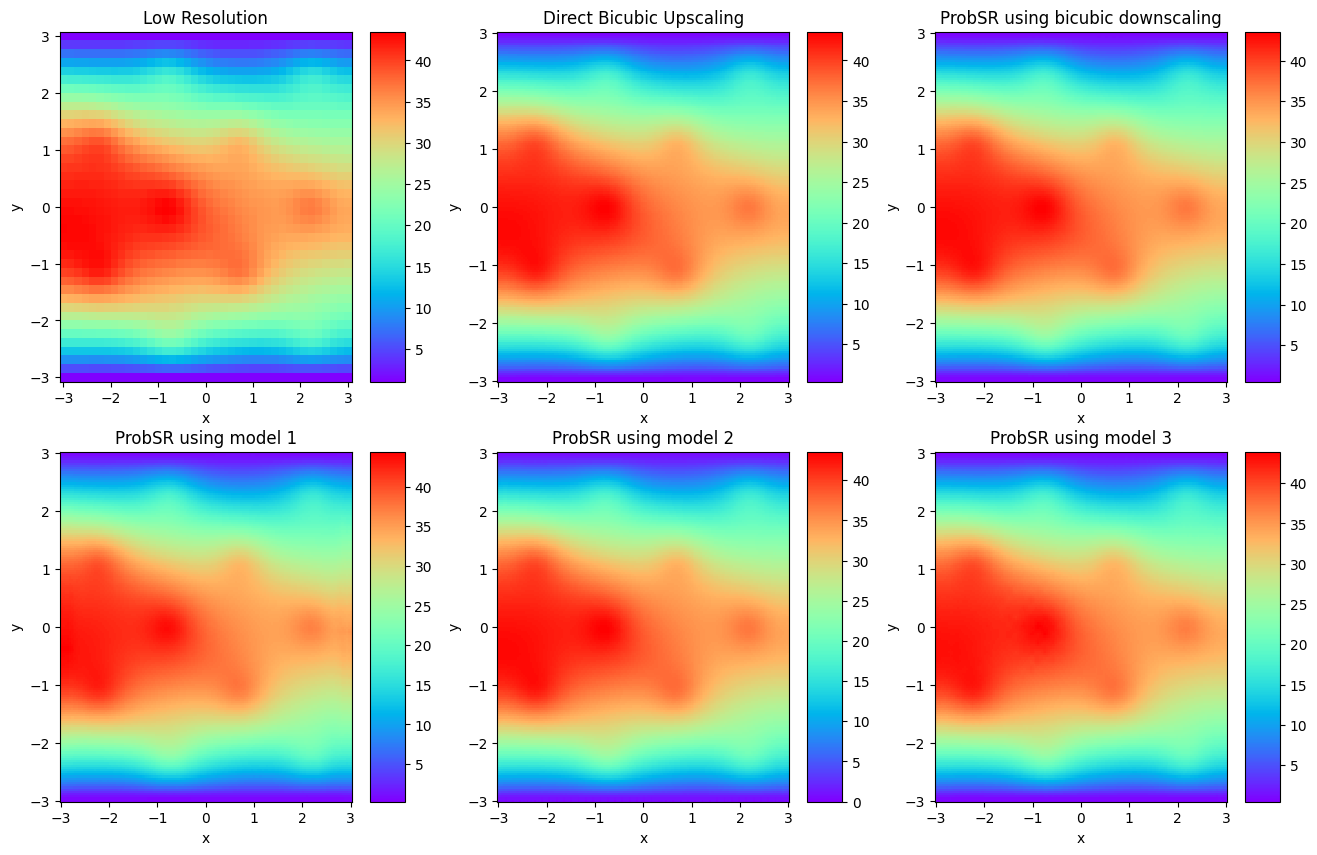

In [38]:
fig = plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.pcolormesh(x_low, y_low, w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('Low Resolution')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(2,3,2)
plt.pcolormesh(x_high,y_high, w_sr, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('Direct Bicubic Upscaling')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(2,3,3)
plt.pcolormesh(x_high,y_high, w_sr_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('ProbSR using bicubic downscaling')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(2,3,4)
plt.pcolormesh(x_high,y_high, w_sr_model1, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('ProbSR using model 1')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(2,3,5)
plt.pcolormesh(x_high,y_high, w_sr_model2, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('ProbSR using model 2')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(2,3,6)
plt.pcolormesh(x_high,y_high, w_sr_model3, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('ProbSR using model 3')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [40]:
import random
total_error1 = 0 # direct bicubic
total_error2 = 0 # bicubic downsampling
total_error3 = 0 # model1
total_error4 = 0 # model2
total_error5 = 0 # model3
# total_error6 = 0 # after pretrain

for i in tqdm(range(40)):
    a = random.uniform(-4,4)
    b = random.uniform(-3,3)
    c = random.uniform(0,3)
    d = random.uniform(-2,2)
    w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c,d)
    w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c,d)
    b_high = create_forcing_term(N_high,a,b,c,d)


    # Direct bicubic
    w_sr = cv2.resize(w_low,(N_high,N_high),interpolation=cv2.INTER_CUBIC)
    error1 = abs(w_high - w_sr)
    total_error1 += (error1**2).sum()/error1.shape[0]**2


    # Parameters for Langevin dynamics
    K = 50
    s = 0.0004


    # Bicubic downsampling
    x = torch.tensor(w_low).to(torch.float32)
    z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode="bicubic").reshape(N_high,N_high)
    z = z.clone().detach().requires_grad_(True)
    chains_evolution = []

    for i in range(K):
        # Grad log-likelihood
        x_hat = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low),mode="bicubic").reshape(N_low,N_low)
        log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
        grad_ll = torch.autograd.grad(log_likelihood, z)[0]

        # startTime = time.time()
        # Grad prior
        difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
        # log_prior = - 0.5 * difference.T @ G_inverse @ difference
        # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
        grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
        grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32)
        #endTime = time.time()
        #print(endTime-startTime)
        # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        # Random noise term
        W = torch.randn(*[N_high,N_high])
        # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W

        if i > K-10:
            chains_evolution.append(z.cpu().data.numpy()) 

    w_sr_bicubic = np.mean(chains_evolution,axis=0)
    error2 = abs(w_high - w_sr_bicubic)
    total_error2 += (error2**2).sum()/error2.shape[0]**2


    # Model 1

    x = torch.tensor(w_low).to(torch.float32).to(device)
    z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode="bicubic").reshape(N_high,N_high)
    z = z.clone().detach().requires_grad_(True)
    chains_evolution = []

    for i in range(K):
        # Grad log-likelihood
        x_hat = G1(z.reshape(1,N_high,N_high)).reshape(N_low,N_low)
        log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
        grad_ll = torch.autograd.grad(log_likelihood, z)[0]
        # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        # Grad prior
        difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
        # log_prior = - 0.5 * difference.T @ G_inverse @ difference
        # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
        grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
        grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
        
        # Random noise term
        W = torch.randn(*[N_high,N_high]).to(device)
        # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W

        if i > K-10:
            chains_evolution.append(z.cpu().data.numpy()) 

    w_sr_model1 = np.mean(chains_evolution,axis=0)
    error3 = abs(w_high - w_sr_model1)
    total_error3 += (error3**2).sum()/error3.shape[0]**2


    # Model 2

    x = torch.tensor(w_low).to(torch.float32).to(device)
    z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode="bicubic").reshape(N_high,N_high)
    z = z.clone().detach().requires_grad_(True)
    chains_evolution = []

    for i in range(K):
        # Grad log-likelihood
        downscaled = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
        x_hat = downscaled + G2(z.reshape(1,1,N_high,N_high)).reshape(N_low,N_low)
        log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
        grad_ll = torch.autograd.grad(log_likelihood, z)[0]
        # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        # Grad prior
        difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
        # log_prior = - 0.5 * difference.T @ G_inverse @ difference
        # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
        grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
        grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
        
        # Random noise term
        W = torch.randn(*[N_high,N_high]).to(device)
        # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W

        if i > K-10:
            chains_evolution.append(z.cpu().data.numpy()) 

    w_sr_model2 = np.mean(chains_evolution,axis=0)
    error4 = abs(w_high - w_sr_model2)
    total_error4 += (error4**2).sum()/error4.shape[0]**2



    # Model 3

    x = torch.tensor(w_low).to(torch.float32).to(device)
    z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode="bicubic").reshape(N_high,N_high)
    z = z.clone().detach().requires_grad_(True)
    chains_evolution = []

    for i in range(K):
        # Grad log-likelihood
        # observation = torch.spmm(H,z.reshape(N_high*N_high,1)).reshape(N_low,N_low)
        downscaled = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
        x_hat = downscaled + G3(downscaled.reshape(1,1,N_low,N_low)).reshape(N_low,N_low)
        log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
        grad_ll = torch.autograd.grad(log_likelihood, z)[0]
        # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        # Grad prior
        difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
        # log_prior = - 0.5 * difference.T @ G_inverse @ difference
        # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
        grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
        grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
        
        # Random noise term
        W = torch.randn(*[N_high,N_high]).to(device)
        # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W

        if i > K-10:
            chains_evolution.append(z.cpu().data.numpy()) 

    w_sr_model3 = np.mean(chains_evolution,axis=0)
    error5 = abs(w_high - w_sr_model3)
    total_error5 += (error5**2).sum()/error5.shape[0]**2



print(total_error1,total_error2,total_error3,total_error4,total_error5)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [05:52<00:00,  8.82s/it]

4.582924842094096 4.432942730694704 6.611593410153287 4.434232572534678 4.535570162735141
